In [1]:
import Base: +, -

function +(a::Tuple{Int64,Int64},b::Tuple{Int64,Int64})
    return (a[1]+b[1],a[2]+b[2])
end

+ (generic function with 164 methods)

In [2]:
function convtomatrix(ar::Array{String,1})
    breadth = length(ar[1])
    depth = length(ar)
    m = Array{Char}(undef, depth, breadth)
    for i in 1:depth
       for j in 1:breadth
            m[i,j] = ar[i][j]
        end
    end
    return m
end

convtomatrix (generic function with 1 method)

In [3]:
mutable struct RaceTrack
    #Z = Wall
    #s = Start
    #o = Track
    #f = Finish
    Shape::Array{Char,2}
    max_velocity::Int64
    position::Array{Int64, 1}
    velocity::Array{Int64,1}
    nrow::Int64
    ncol::Int64
    noise::Float64
    
    function RaceTrack(Shape; max_velocity =5, noise = 0.1)
        shapematrix = convtomatrix(Shape)
        pos = random_start(shapematrix)
        nrow = size(shapematrix)[1]
        ncol = size(shapematrix)[2]
        new(shapematrix, max_velocity, pos,[0,0],nrow,ncol,noise)
    end
    
end


function velocity_change(r::RaceTrack, change::Array{Int64,1})
    if rand() > r.noise      #Probability noise of not changing Velocity
        r.velocity = r.velocity + change
        r.velocity = min.(r.velocity, r.max_velocity)
        r.velocity = max.(r.velocity,0)
    end
end

function random_start(Shape::Array{Char,2})
    start_indices = findall(x -> x=='s', Shape)  
    nstarts = length(start_indices)
    randomstart = start_indices[rand(1:nstarts)]
    pos = [0,0]
    pos[1] = randomstart[1]
    pos[2] = randomstart[2]
    return pos
end

function pos_change(r::RaceTrack)
    current_pos = r.position
    #new_pos = r.position + r.velocity
    nsteps = sum(r.velocity)
    steps_up = 0
    steps_r = 0
    #Randomly move one up or right until maximum steps are reached
    while (steps_up < r.velocity[1]) | (steps_r < r.velocity[2])
        rorup = rand(1:2)    #Select random move
        if (rorup == 1) & (steps_up == r.velocity[1])
            rorup = 2
        elseif (rorup ==2) & (steps_r == r.velocity[2])
            rorup = 1
        end
        
        #println("HELP")
        if rorup == 1
            current_pos[1] -= 1    #move up one
            steps_up +=1
            #rintln("up")
           #println(current_pos)
            if wallcheck(r.Shape,current_pos)
                r.position = random_start(r.Shape)   #Ran into wall -> Back to start
                r.velocity = [0,0]                   #Reset velocity
                return 0
            elseif fincheck(r.Shape,current_pos)     #Finished -> Done
                return 1
            end

        else
            current_pos[2] += 1    #move right one
            steps_r +=1
            #rintln("right")
            #rintln(current_pos)
            if wallcheck(r.Shape,current_pos)
                r.position = random_start(r.Shape)   #Ran into wall -> Back to start
                r.velocity = [0,0]                   #Reset velocity
                return 0
            elseif fincheck(r.Shape,current_pos)     #Finished -> Done
                return 1
            end

        end
        
     end
    
    r.position = current_pos      #Update position after not running into Wall/Finish
    
end

function wallcheck(shape::Array{Char,2}, pos::Array{Int64,1})
    return (shape[pos[1],pos[2]] == 'Z')
end

function fincheck(shape::Array{Char,2}, pos::Array{Int64,1})
    return (shape[pos[1],pos[2]] == 'f')
end

function take_action(r::RaceTrack, action::Int64)
    #Take action, return reward
    #Convert Action-Number to actual Values
    if action == 1
        change = [0,0]
    elseif action == 2
        change = [1,0]
    elseif action == 3
        change = [0,1]
    elseif action == 4
        change = [1,1]
    elseif action == 5
        change = [-1,1]
    elseif action == 6
        change = [1,-1]
    elseif action == 7
        change = [-1,-1]
    elseif action == 8
        change = [0,-1]   
    else change = [-1,0]
        
    end
    
    
    current_pos = r.Shape[r.position[1],r.position[2]]
    
    #A_t
    velocity_change(r, change)
    
    #R_t and Environment Control
    if current_pos == 'f'       
        r.position = random_start(r.Shape)       #Reset Environment
        r.velocity = [0,0]
        return (0,true)                          #Return Tuple (a = reward, b = done)
        
    else
        #S_t+1
        pos_change(r)
        return (-1,false)
    end
    
end


function generate_episode(b::Any,r::RaceTrack,deterministic = false)
    isDone = false
    S = []
    A = []
    R = []
    while !isDone
        #println(r.position)
        push!(S, [r.position[1],r.position[2],r.velocity[1]+1,r.velocity[2]+1])
        if deterministic
            action = Int(b[r.position[1],r.position[2],
                    r.velocity[1]+1,r.velocity[2]+1])

        else
            
            action = sample(Weights(b[r.position[1],r.position[2],
                    r.velocity[1]+1,r.velocity[2]+1]))
        end
        push!(A, action)
        
        (reward,isDone) = take_action(r,action)
        
        push!(R,reward)
    end
    return (S,A,R)
end



generate_episode (generic function with 2 methods)

In [4]:
Track2 = [
    "ZZZZZZZZZZZZZZ",
    "ZZZZZoooooooof",
    "ZZZZooooooooof",
    "ZZZoooooooooof",
    "ZZoooooooooooZ",
    "ZZoooooooooooZ",
    "ZooooooooooooZ",
    "ZooooooooooooZ",
    "ZssssssssssssZ"
]

Track3 = [
    "ZZZZZZZZZZZZZZZZZZZZZZZZ",
    "ZZooooooooooooooooooooof",
    "ZZZZooooooooooooooooooof",
    "ZZZZZoooooooooooooooooof",
    "ZZZZZZoooooooooooooooooZ",
    "ZZZZZZZZoooooooooooooooZ",
    "ZZZZZZZooooooooooooooooZ",
    "ZZZZZoooooooooooooooooZZ",
    "ZZZooooooooooooooooooZZZ",
    "ZZooooooooooooooooooooZZ",
    "ZZZZZssssssssssssssZZZZZ"
    ]

Track4 = [
    "ZZZZZ"
    "Zooof"
    "Zooof"
    "ZoooZ"
    "ZsssZ"
]

Track = [ 
  "ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ"  
  "ZZZZZZZZZZZZZZZZZZZoooooooooooooooooooff"   
  "ZZZZZZZZZZZZZZZoooooooooooooooooooooooff"
  "ZZZZZZZZZZZZZoooooooooooooooooooooooooff"
  "ZZZZZZZZZZZoooooooooooooooooooooooooooff"  
  "ZZZZZZZZZooooooooooooooooooooZZZZZZZZZZZ"  
  "ZZZZZZoooooooooooooZZZZZZZZZZZZZZZZZZZZZ"  
  "ZZZZoooooooooooooZZZZZZZZZZZZZZZZZZZZZZZ"  
  "ZZZZooooooooooooooZZZZZZZZZZZZZZZZZZZZZZ"  
  "ZZZZZZooooooooooooooZZZZZZZZZZZZZZZZZZZZ"  
  "ZZZZZZZZZZooooooooooooZZZZZZZZZZZZZZZZZZ"   
  "ZZZZZZZZZZZZooooooooooooZZZZZZZZZZZZZZZZ"
  "ZZZZZZZZZZZZZZoooooooooooZZZZZZZZZZZZZZZ" 
  "ZZZZZZZZZZZZooooooooooooZZZZZZZZZZZZZZZZ"
  "ZZZZZZZZZZooooooooooooZZZZZZZZZZZZZZZZZZ" 
  "ZZZZZZZZoooooooooooooZZZZZZZZZZZZZZZZZZZ"  
  "ZZZZZZooooooooooooooZZZZZZZZZZZZZZZZZZZZ"  
  "ZZZZooooooooooooooZZZZZZZZZZZZZZZZZZZZZZ"
  "ZZooooooooooooooZZZZZZZZZZZZZZZZZZZZZZZZ"  
  "sssssssssssssssZZZZZZZZZZZZZZZZZZZZZZZZZ"  
]


20-element Array{String,1}:
 "ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ"
 "ZZZZZZZZZZZZZZZZZZZoooooooooooooooooooff"
 "ZZZZZZZZZZZZZZZoooooooooooooooooooooooff"
 "ZZZZZZZZZZZZZoooooooooooooooooooooooooff"
 "ZZZZZZZZZZZoooooooooooooooooooooooooooff"
 "ZZZZZZZZZooooooooooooooooooooZZZZZZZZZZZ"
 "ZZZZZZoooooooooooooZZZZZZZZZZZZZZZZZZZZZ"
 "ZZZZoooooooooooooZZZZZZZZZZZZZZZZZZZZZZZ"
 "ZZZZooooooooooooooZZZZZZZZZZZZZZZZZZZZZZ"
 "ZZZZZZooooooooooooooZZZZZZZZZZZZZZZZZZZZ"
 "ZZZZZZZZZZooooooooooooZZZZZZZZZZZZZZZZZZ"
 "ZZZZZZZZZZZZooooooooooooZZZZZZZZZZZZZZZZ"
 "ZZZZZZZZZZZZZZoooooooooooZZZZZZZZZZZZZZZ"
 "ZZZZZZZZZZZZooooooooooooZZZZZZZZZZZZZZZZ"
 "ZZZZZZZZZZooooooooooooZZZZZZZZZZZZZZZZZZ"
 "ZZZZZZZZoooooooooooooZZZZZZZZZZZZZZZZZZZ"
 "ZZZZZZooooooooooooooZZZZZZZZZZZZZZZZZZZZ"
 "ZZZZooooooooooooooZZZZZZZZZZZZZZZZZZZZZZ"
 "ZZooooooooooooooZZZZZZZZZZZZZZZZZZZZZZZZ"
 "sssssssssssssssZZZZZZZZZZZZZZZZZZZZZZZZZ"

In [5]:
r = RaceTrack(Track)
r

RaceTrack(['Z' 'Z' … 'Z' 'Z'; 'Z' 'Z' … 'f' 'f'; … ; 'Z' 'Z' … 'Z' 'Z'; 's' 's' … 'Z' 'Z'], 5, [20, 14], [0, 0], 20, 40, 0.1)

In [13]:
using StatsBase

function generate_behavior(r::RaceTrack)
    b = Array{Any}(undef,r.nrow, r.ncol, r.max_velocity+1, r.max_velocity+1)
    for i in 1:r.nrow, j in 1:r.ncol, k in 1:r.max_velocity+1, l in 1:r.max_velocity+1
        z = rand(9)                               #Total of 9 Actions
        b[i,j,k,l] = (exp.(z))/(sum(exp.(z)))     #softmax
    end
    return b
end


#Off policy MC Control for estimating π ≈ π*
gamma = 0.8  #Discount Factor

r = RaceTrack(Track,noise = 0.1)
Q = rand(r.nrow, r.ncol, r.max_velocity+1, r.max_velocity+1, 9)      
C = zeros(r.nrow, r.ncol, r.max_velocity+1, r.max_velocity+1, 9) 

policy = zeros(Int64,r.nrow, r.ncol, r.max_velocity+1, r.max_velocity+1)

for i in 1:r.nrow, j in 1:r.ncol, k in 1:r.max_velocity+1, l in 1:r.max_velocity+1
    policy[i,j,k,l] = argmax(Q[i,j,k,l,:])
end

#Learning see below
policy2 = copy(policy);
b = generate_behavior(r);


In [9]:
using ProgressMeter
upcount = 0
percentage = 0
nits = 10^(5.0)


for episode in 1:nits

     if episode % (nits/100) == 0
        percentage +=1
        print("\r")
        print("\r $(percentage)% trained, Policy updated $(upcount) times. ")
    end
    if episode % (nits/100) == 0
        b = generate_behavior(r)
    end

    (S,A,R) = generate_episode(b,r)
    

    G = 0
    W = 1
    for t in length(S): -1 : 1
        G = gamma*G + R[t]
        #println(G)
        C[S[t][1], S[t][2], S[t][3], S[t][4], A[t]] += W
        
        Q[S[t][1], S[t][2], S[t][3], S[t][4], A[t]] += 
        (W/C[S[t][1], S[t][2], S[t][3], S[t][4], A[t]])
        *(G - Q[S[t][1], S[t][2], S[t][3], S[t][4], A[t]] )
        
        if(policy[S[t][1],S[t][2],S[t][3],S[t][4]]!== argmax(Q[S[t][1], S[t][2], S[t][3], S[t][4],:]))
            upcount +=1
        end
        
        policy[S[t][1],S[t][2],S[t][3],S[t][4]]= argmax(Q[S[t][1], S[t][2], S[t][3], S[t][4],:])

        if A[t] !== Int(policy[S[t][1],S[t][2],S[t][3],S[t][4]])    
            break
        end
        W = W * (1/b[S[t][1],S[t][2],S[t][3],S[t][4]][A[t]])
        #println(W)
        #W = W*2
    end
end


ArgumentError: ArgumentError: Package ProgressMeter not found in current path:
- Run `import Pkg; Pkg.add("ProgressMeter")` to install the ProgressMeter package.


In [244]:
r = RaceTrack(Track,noise = 0)

RaceTrack(['Z' 'Z' … 'Z' 'Z'; 'Z' 'Z' … 'f' 'f'; … ; 'Z' 'Z' … 'Z' 'Z'; 's' 's' … 'Z' 'Z'], 5, [20, 11], [0, 0], 20, 40, 0.0)

In [245]:
samplestates = generate_episode(policy,r,true)[1]
samplepos = zeros(Int64,length(samplestates),2)
for i in 1:length(samplestates)
    samplepos[i,1] = samplestates[i][1]
    samplepos[i,2] = samplestates[i][2]
end

trajmat = zeros(r.nrow,r.ncol)


for i in 1:r.nrow, j in 1:r.ncol
    if r.Shape[i,j] == 'Z'
        trajmat[i,j] = 1
    elseif r.Shape[i,j] == 'f'
        trajmat[i,j] = 2
    elseif r.Shape[i,j] == 's'
        trajmat[i,j] = 3
    end
end
for i in 1:length(samplestates)
    trajmat[samplepos[i,1],samplepos[i,2]] = 4
end


InterruptException: InterruptException:

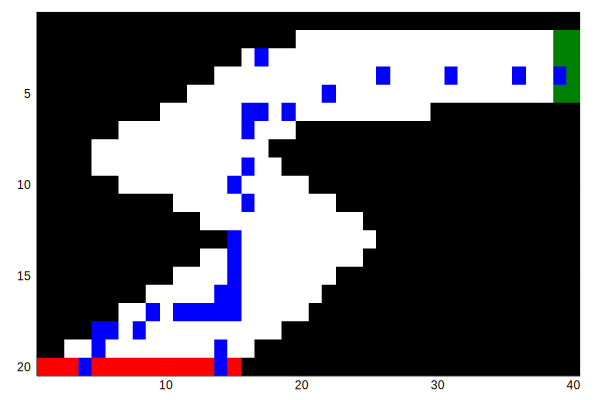

In [220]:
#Plotting sample trajectory without noise
using Plots

traj = heatmap(trajmat,cbar = false, color = cgrad([:white, :black, :green ,:red,:blue]),
    yflip = true)


In [431]:
avglen = 0
b = generate_behavior(r)
for i in 1:100000
    avglen += length(generate_episode(b,r)[1])
end
avglen/100000

22.97489

In [430]:
avglen = 0
for i in 1:100000
    avglen += length(generate_episode(policy,r,true)[1])
end
avglen/100000

6.43027

In [39]:
b = generate_behavior(r);


In [49]:
length(generate_episode(b,r)[1])

16111